<a href="https://colab.research.google.com/github/nshaganti/nshaganti-difference-in-differences-lp/blob/main/Analysis_Code_DID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/nshaganti/nshaganti-difference-in-differences-lp.git

Cloning into 'nshaganti-difference-in-differences-lp'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 1), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 1.06 MiB | 2.71 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import os
repo = 'nshaganti-difference-in-differences-lp'
if os.getcwd().split("/")[-1] == repo:
  print("Already in the correct directory")
else:
  os.chdir(repo)
  print(f"Changed working directory to: {repo}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import graphviz as gr

warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Changed working directory to: nshaganti-difference-in-differences-lp


In [3]:
data = pd.read_csv("diff_in_diff.csv")

In [6]:
data.shape

(50000, 8)

In [7]:
data.head()

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4


In [8]:
# understand the inferred data types
data.dtypes

,0
sales,float64
discount,int64
age,int64
gender,object
cust_state,object
tenure,int64
profit,float64
month,int64


In [9]:
# check for any missing data
data.isna().sum()

,0
sales,0
discount,0
age,0
gender,4965
cust_state,0
tenure,0
profit,0
month,0


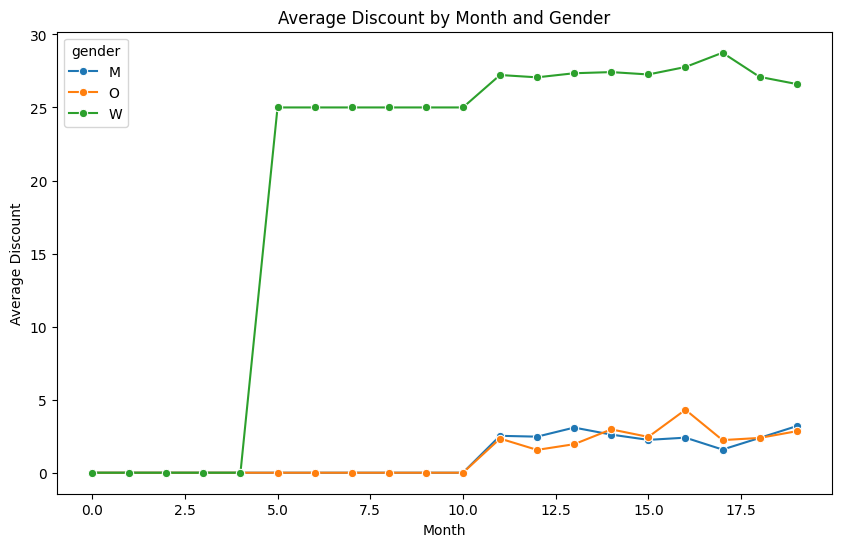

In [11]:
# Group data by month and gender, then calculate the average discount
agg_discount = data.groupby(['month', 'gender'])['discount'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='discount', hue='gender', data=agg_discount, marker='o')
plt.title('Average Discount by Month and Gender')
plt.xlabel('Month')
plt.ylabel('Average Discount')
plt.show()

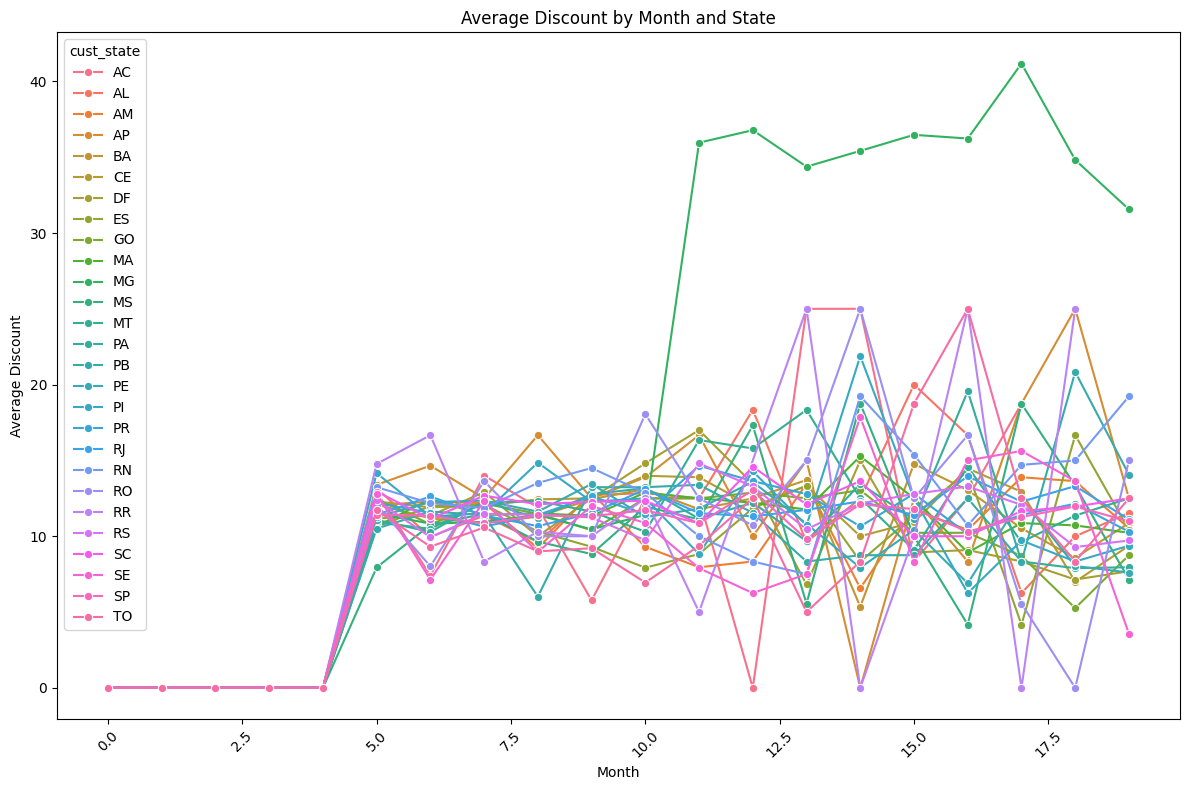

In [19]:
# Group data by customer state and month
state_df = data.groupby(['cust_state', 'month'])[['profit', 'discount']].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='month', y='discount', hue='cust_state', data=state_df, marker='o')
plt.title('Average Discount by Month and State')
plt.xlabel('Month')
plt.ylabel('Average Discount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

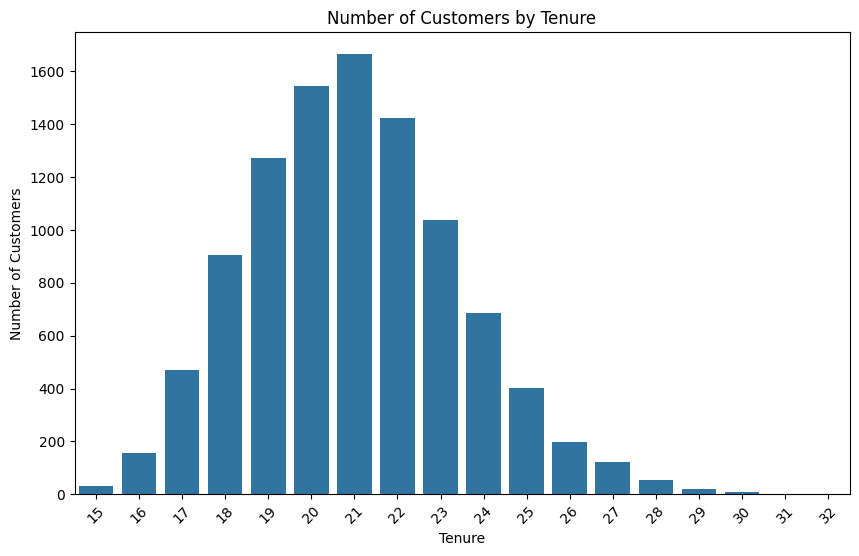

In [ ]:
# Group data by tenure and count customers
tenure_counts = data.groupby('tenure').size().reset_index(name='customer_count')

# Plot tenure vs. customer count
plt.figure(figsize=(10, 6))
sns.barplot(x='tenure', y='customer_count', data=tenure_counts)
plt.title('Number of Customers by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Check for bunching visually - look for unusually high counts at specific tenure values
#  A sudden increase or decrease in customer counts might suggest bunching.
#  Examine the plot to see if any tenure points have significantly more customers than their neighbors.

In [ ]:
rdd_centered = data.copy()

# Center tenure at zero
rdd_centered['tenure'] = rdd_centered['tenure'] - 19

# Create the above_threshold column
rdd_centered['above_threshold'] = np.where(rdd_centered['tenure'] > 0, 1, 0)

In [ ]:
rdd_centered.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,spend_5m_clothes,spend_6m_clothes,spend_1m_health,spend_2m_health,spend_3m_health,spend_4m_health,spend_5m_health,spend_6m_health,spend_1m_pet,spend_2m_pet,spend_3m_pet,spend_4m_pet,spend_5m_pet,spend_6m_pet,spend_1m_groceries,spend_2m_groceries,spend_3m_groceries,spend_4m_groceries,spend_5m_groceries,spend_6m_groceries,spend_1m_eletronic,spend_2m_eletronic,spend_3m_eletronic,spend_4m_eletronic,spend_5m_eletronic,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,profits,above_threshold
0,5,0,0,0,10,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,55,180,20.000000,10.000000,15.0,40.0,0,0,0,0.0,0.0,0.0,1442.30,4.0,66.93,30,0.0,MA,0,68.1150,0
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0.000000,0.000000,0.0,0.0,0,0,0,0.0,0.0,0.0,883.96,2.0,41.33,30,1.0,MG,1,42.1980,1
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,25,10,254.255197,289.255197,65.0,30.0,0,0,0,0.0,0.0,0.0,4900.67,224.0,15.88,29,0.0,RJ,2,21.0335,1
3,0,0,0,0,0,0.0,25,25.0,0.0,25.0,25.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,30,10,5.000000,30.000000,0.0,45.0,0,0,0,0.0,0.0,0.0,1547.48,1.0,74.99,36,1.0,BA,-1,76.3740,0
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0.000000,10.000000,0.0,45.0,0,0,0,0.0,0.0,0.0,1335.23,13.0,52.41,37,0.0,PB,0,53.7615,0


Fitting a linear regression interacting tenure with the threshold dummy

$$
discount_i = \beta_0 + \beta_1 tenure_i + \beta_2 \mathcal{1}_{tenure>19} + \beta_3 \mathcal{1}_{tenure>19} * tenure
$$

is equivalent to fitting two regression models: one above and another below the threshold. \\(\beta_0\\) is the intercept for the model below the threshold. \\(\beta_0+\beta_2\\) is the intercept for the model above the threshold. Hence, \\(\beta_2\\) is the jump we have from crossing the threshold. This is exactly the treatment effect we are looking for.

This means that crossing the 20th month threshold increases discount by about `184` (95% CI between 173	and 195). This is a statistically significant difference.

In [ ]:
discount_model = smf.ols('discount ~ above_threshold*tenure', data=rdd_centered).fit()

# Print the model summary
print(discount_model.summary())

                            OLS Regression Results                            
Dep. Variable:               discount   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     857.2
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        04:32:49   Log-Likelihood:                -65365.
No. Observations:               10000   AIC:                         1.307e+05
Df Residuals:                    9996   BIC:                         1.308e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10

In [ ]:
# Group rdd_centered by tenure and aggregate discount and above_threshold with the mean
grouped_data = rdd_centered.groupby('tenure').agg({'discount': 'mean', 'above_threshold': 'mean'}).reset_index()

# Make predictions using the fitted model
grouped_data['prediction'] = discount_model.predict(grouped_data)
grouped_data

,tenure,discount,above_threshold,prediction
0,-4,11.606061,0.0,9.582855
1,-3,8.721519,0.0,9.694702
2,-2,9.633262,0.0,9.806550
3,-1,10.313053,0.0,9.918397
4,0,9.882168,0.0,10.030244
5,1,193.134067,1.0,195.731588
6,2,201.152553,1.0,196.670351
7,3,200.239635,1.0,197.609115
8,4,191.514947,1.0,198.547879
9,5,194.991266,1.0,199.486642


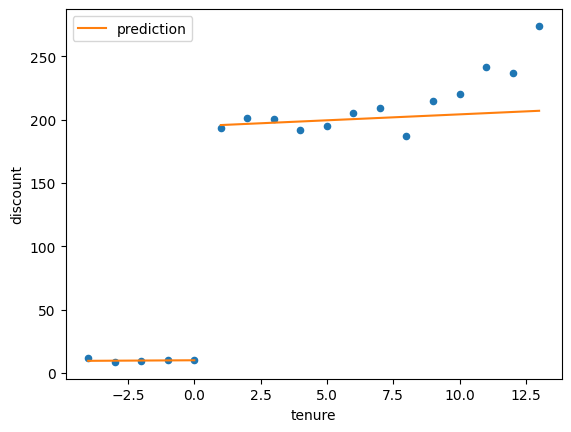

In [ ]:
ax = grouped_data.plot.scatter(x="tenure", y="discount", color="C0")
grouped_data.query("above_threshold<=0").plot(x="tenure", y="prediction", ax=ax, color="C1")
grouped_data.query("above_threshold>0").plot(x="tenure", y="prediction", ax=ax, color="C1", legend=False)
plt.show()

In [ ]:
profit_model = smf.ols("profit ~ tenure*above_threshold", rdd_centered).fit()

# Print the model summary
print(profit_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.04
Date:                Sun, 23 Feb 2025   Prob (F-statistic):           4.90e-11
Time:                        05:16:24   Log-Likelihood:                -52868.
No. Observations:               10000   AIC:                         1.057e+05
Df Residuals:                    9996   BIC:                         1.058e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 53

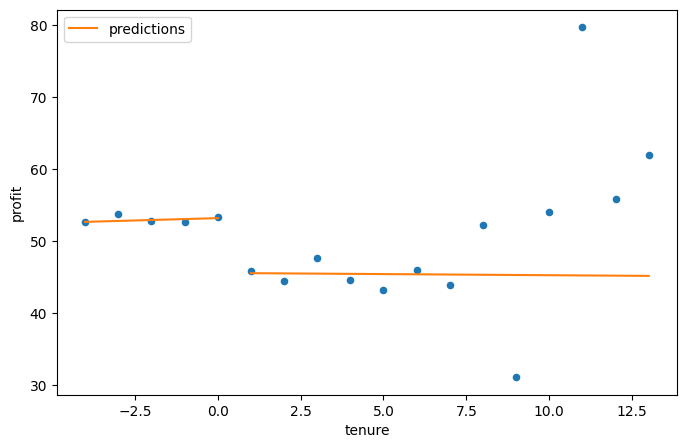

In [ ]:
rdd_group_pred = (rdd_centered
                  .groupby("tenure")
                  [["profit", "above_threshold"]]
                  .mean()
                  .reset_index())

rdd_group_pred["predictions"] = profit_model.predict(rdd_group_pred)


ax = rdd_group_pred.plot.scatter(x="tenure", y="profit", color="C0")
rdd_group_pred.query("above_threshold<=0").plot(x="tenure", y="predictions", ax=ax, color="C1", figsize=(8,5))
rdd_group_pred.query("above_threshold>0").plot(x="tenure", y="predictions", ax=ax, color="C1", legend=False)
plt.show()

In [ ]:
# Kernel Weights for Better Extrapolation

def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

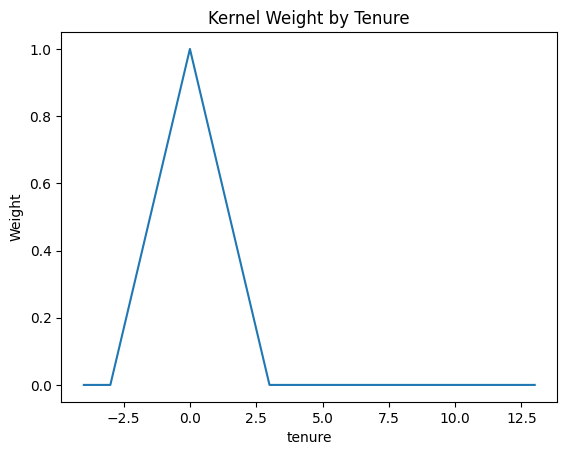

In [ ]:
all_tenures  = np.array(sorted(rdd_centered["tenure"].unique()))

plt.plot(all_tenures, kernel(all_tenures, c=0, h=3))
plt.xlabel("tenure")
plt.ylabel("Weight")
plt.title("Kernel Weight by Tenure")
plt.show()

In [ ]:
model = smf.wls("profit ~ tenure*above_threshold",
                weights=kernel(rdd_centered["tenure"], c=0, h=4),
               data=rdd_centered).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     27.51
Date:                Sun, 23 Feb 2025   Prob (F-statistic):           1.04e-17
Time:                        05:39:15   Log-Likelihood:                   -inf
No. Observations:               10000   AIC:                               inf
Df Residuals:                    9996   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 53

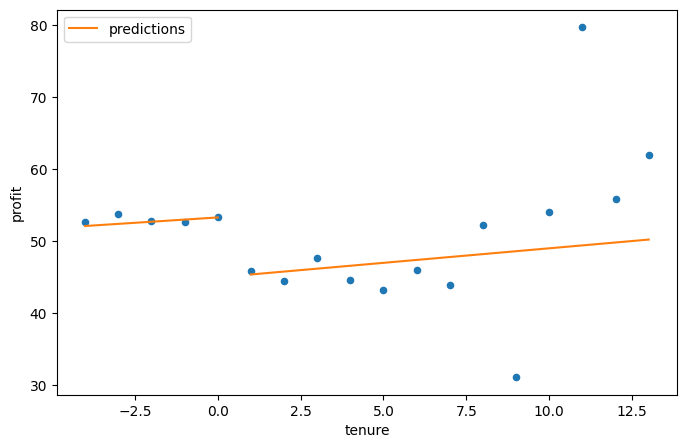

In [ ]:
rdd_group_pred = (rdd_centered
                  .groupby("tenure")
                  [["profit","above_threshold"]]
                  .mean()
                  .reset_index())

rdd_group_pred["predictions"] = model.predict(rdd_group_pred)


ax = rdd_group_pred.plot.scatter(x="tenure", y="profit", color="C0")
rdd_group_pred.query("above_threshold<=0").plot(x="tenure", y="predictions", ax=ax, color="C1", figsize=(8,5))
rdd_group_pred.query("above_threshold>0").plot(x="tenure", y="predictions", ax=ax, color="C1", legend=False)
plt.show()